# Prepare DSI Fragments for Docking

8th June 2022 - Notebook for loading and preparing DSI Enamine fragment library for docking against Mpro.

In [7]:
import pandas as pd

data_dir = '/Users/williammccorkindale/ml_physics/PhD_data/FRESCO/DSI_poised_Enamine_fragment_library'

df_frags = pd.read_csv(f'{data_dir}/DSI_lib.csv')
df_frags


,ID,Formula,MW,Purity,Salt_name,Salt_ratio,MW_salt,Well,Smile,Structure,Name,500 mM solubility comment
0,Z31735562,C11H14N2O3,222.25,98.0,NaN,0,0.0,AA07,COCC(=O)NC=1C=CC=C(NC(=O)C)C1,NaN,N-(3-acetamidophenyl)-2-methoxyacetamide,NaN
1,Z1650040241,C7H14N2O,142.20,95.0,NaN,0,0.0,F07,CCC(=O)NC1CCNC1,NaN,N-(pyrrolidin-3-yl)propanamide,NaN
2,Z263785508,C6H9N3O2S,187.22,98.0,NaN,0,0.0,G07,COCC(=O)NC1=NN=C(C)S1,NaN,"2-methoxy-N-(5-methyl-1,3,4-thiadiazol-2-yl)ac...",not completely soluble at 500 mM
3,Z275181224,C12H14N4O,230.27,100.0,NaN,0,0.0,H07,CCN1C=C(CNC(=O)C=2C=CC=NC2)C=N1,NaN,N-[(1-ethyl-1H-pyrazol-4-yl)methyl]pyridine-3-...,NaN
4,Z276545932,C12H11N5O,241.25,100.0,NaN,0,0.0,I07,COC=1C=CC(NC=2N=CN=C3NC=NC23)=CC1,NaN,N-(4-methoxyphenyl)-9H-purin-6-amine,not completely soluble at 500 mM
...,...,...,...,...,...,...,...,...,...,...,...,...
763,Z19731563,C13H14N2O3,246.27,100.0,NaN,0,0.0,U41,CC1=CC(NC(=O)COC=2C=CC(C)=CC2)=NO1,NaN,"N-(5-methyl-1,2-oxazol-3-yl)-2-(4-methylphenox...",NaN
764,Z2856434834,C14H20N2O2,248.33,97.0,NaN,0,0.0,V41,CC=1C=CC=C(NC(=O)CN2CCOCC2)C1C,NaN,"N-(2,3-dimethylphenyl)-2-(morpholin-4-yl)aceta...",NaN
765,Z57282999,C8H11N3O3,197.20,100.0,NaN,0,0.0,W41,O=C1NC=C(N2CCOCC2)C(=O)N1,NaN,"5-(morpholin-4-yl)-1,2,3,4-tetrahydropyrimidin...",not completely soluble at 500 mM
766,Z31480458,C15H21NO2,247.34,100.0,NaN,0,0.0,X41,CC(C)COC=1C=CC(=CC1)C(=O)N2CCCC2,NaN,1-[4-(2-methylpropoxy)benzoyl]pyrrolidine,NaN


Add hydrogens, generate conformer, and write to file

In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem
from ccdc.molecule import Molecule

prep_frag_dir = '/Users/williammccorkindale/ml_physics/smi2wyck/notebooks/docking/prepared_ligands/DSI_lib'

for _, row in df_frags.iterrows():
    
    mol = Chem.MolFromSmiles(row['Smile'])
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    mol_block = Chem.MolToMolBlock(mol)
    prepared_csd_mol = Molecule.from_string(mol_block)
    with open(f'{prep_frag_dir}/prepared_{row.ID}.mol2', 'w') as writer:
        writer.write(prepared_csd_mol.to_string('mol2'))
    


Naive dock

In [4]:
import tempfile
from ccdc.docking import Docker
from ccdc.io import MoleculeReader, EntryReader

def return_mpro_docker(results_dir):

    docker = Docker()
    settings = docker.settings

    mpro_dir = 'mpro_protein'

    mpro_protein_file = f'{mpro_dir}/6LU7_protein.mol2'
    settings.add_protein_file(mpro_protein_file)

    mpro_native_ligand_file = f'{mpro_dir}/6LU7_ligand.mol2'
    mpro_native_ligand = MoleculeReader(mpro_native_ligand_file)[0]

    mpro_protein = settings.proteins[0]
    settings.binding_site = settings.BindingSiteFromLigand(mpro_protein, mpro_native_ligand, 8.0)

    settings.fitness_function = 'plp'
    settings.autoscale = 10.
    settings.early_termination = False
    settings.write_options = 'NO_RNK_FILES'
    settings.write_options = 'NO_GOLD_LIGAND_MOL2_FILE'
    settings.write_options = 'NO_LOG_FILES'
    
    batch_tempd = tempfile.mkdtemp()
    settings.output_directory = results_dir
    settings.output_file = 'docked_ligands.mol2'
    
    return docker

results_dir = '/Users/williammccorkindale/ml_physics/smi2wyck/notebooks/docking/results/DSI'
docker = return_mpro_docker(results_dir)
n_docks = 5
for _, row in df_frags.iterrows():
    
    docker.settings.add_ligand_file(f'{prep_frag_dir}/prepared_{row.ID}.mol2', ndocks=n_docks)

results = docker.dock() 
if results.return_code == 0 and results.ligands[0].fitness() is not None:
    print('Docking successful')
    
    print(f'{len(results.ligands)} Docks completed')

else:
    print('Something went wrong...')

Starting GOLD with conf file /Users/williammccorkindale/ml_physics/smi2wyck/notebooks/docking/api_gold.conf
Setting up GOLD environment...
GOLD Version 2022.1.0
Running:
 
     "/Applications/CCDC/Discovery_2022/GOLD/gold/d_macx/bin/gold_macx" "/Users/williammccorkindale/ml_physics/smi2wyck/notebooks/docking/api_gold.conf"

Docking successful
3840 Docks completed


In [5]:
total_scores = []
for ligand in results.ligands:
    total_scores.append(ligand.fitness())

In [6]:
import plotly.express as px

px.histogram(total_scores)

/Users/williammccorkindale/miniconda3/envs/csd_env/lib/python3.7/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/williammccorkindale/miniconda3/envs/csd_env/lib/python3.7/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



@<TRIPOS>MOLECULE
unknown|prepared_Mpro-x0354|mol2|1|dock4
    43    44     1     0     0
SMALL
NO_CHARGES
****
Generated from the CSD

@<TRIPOS>ATOM
     1 C1     -12.2848  12.9007  63.3895   C.3       1 RES1   0.0000
     2 N2     -11.2670  13.2863  64.3173   N.4       1 RES1   0.0000
     3 C3     -10.2703  12.2685  64.4510   C.3       1 RES1   0.0000
     4 C4     -10.7867  11.0560  65.2218   C.3       1 RES1   0.0000
     5 N5     -11.3138  11.5483  66.4627   N.am      1 RES1   0.0000
     6 C6     -12.3021  12.5937  66.4412   C.3       1 RES1   0.0000
     7 C7     -11.7562  13.7176  65.5874   C.3       1 RES1   0.0000
     8 C8     -10.8601  11.0053  67.6845   C.2       1 RES1   0.0000
     9 O9      -9.9948  10.0897  67.7308   O.2       1 RES1   0.0000
    10 C10    -11.4181  11.5272  68.9538   C.3       1 RES1   0.0000
    11 O11    -11.2354  12.9214  68.9798   O.3       1 RES1   0.0000
    12 C12    -11.7887  13.6501  70.0349   C.ar      1 RES1   0.0000
    13 C13    -12.5910

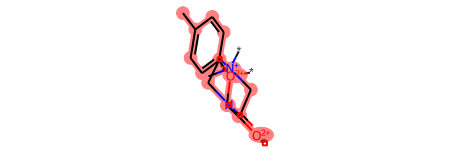

In [146]:
from rdkit.Chem.rdmolfiles import MolFromMol2Block

# for ligand in results.ligands:
docked_mol_block = results.ligands[2].molecule.to_string()
print(docked_mol_block)
rdkit_mol = MolFromMol2Block(docked_mol_block)
mol_from_smiles_file = Chem.MolFromSmiles(df_frags.smiles.values[0])
ref_mol = AllChem.AssignBondOrdersFromTemplate(mol_from_smiles_file, rdkit_mol)
ref_mol

In [17]:
df_scores = pd.DataFrame(columns=['RealCrystalName', 'smiles', 'score'])

for index, row in df_frags.iterrows():
    for ligand_index in range(index*n_docks, (index+1)*n_docks):
        try:
            ligand = results.ligands[ligand_index]
            score = ligand.fitness()
            df_scores = df_scores.append({'RealCrystalName': row.RealCrystalName, 'smiles': row.smiles, 'ligand_index': ligand_index - index*n_docks, 'score': score}, ignore_index=True)
        except:
            pass
df_scores

,RealCrystalName,smiles,score,ligand_index
0,Mpro-x0354,CN1CCN(CC1)C(=O)COC=2C=CC(C)=CC2,44.9205,0.0
1,Mpro-x0354,CN1CCN(CC1)C(=O)COC=2C=CC(C)=CC2,48.1828,1.0
2,Mpro-x0426,FC=1C=CC=CC1C(=O)NCCC=2C=CN=CC2,57.3072,0.0
3,Mpro-x0426,FC=1C=CC=CC1C(=O)NCCC=2C=CN=CC2,49.9935,1.0
4,Mpro-x0104,CC(=O)NCCC1=CNC=2C=CC(F)=CC12,44.5659,0.0
5,Mpro-x0104,CC(=O)NCCC1=CNC=2C=CC(F)=CC12,50.3251,1.0
6,Mpro-x0195,CN1CCCC=2C=CC(=CC12)S(=O)(=O)N,40.3705,0.0
7,Mpro-x0195,CN1CCCC=2C=CC(=CC12)S(=O)(=O)N,43.2479,1.0
8,Mpro-x0072,CS(=O)(=O)NCCC=1C=CC=CC1,44.4608,0.0
9,Mpro-x0072,CS(=O)(=O)NCCC=1C=CC=CC1,47.1679,1.0


In [18]:
df_best_poses = df_scores.sort_values(by='score', ascending=False).drop_duplicates(subset=['RealCrystalName', 'smiles'], keep='first').astype({'ligand_index': int})
df_best_poses

,RealCrystalName,smiles,score,ligand_index
36,Mpro-x0540,O=C(NCCC=1C=CN=CC1)NC2CCCCC2,58.0547,0
2,Mpro-x0426,FC=1C=CC=CC1C(=O)NCCC=2C=CN=CC2,57.3072,0
26,Mpro-x1093,CN1CCN(CC1)C(=O)CC1=CNC2=NC=CC=C12,52.5756,0
30,Mpro-x0967,CC(=O)NC(Cc1ccc(cc1)O)C(=O)NCC#CBr,51.2811,0
5,Mpro-x0104,CC(=O)NCCC1=CNC=2C=CC(F)=CC12,50.3251,1
1,Mpro-x0354,CN1CCN(CC1)C(=O)COC=2C=CC(C)=CC2,48.1828,1
9,Mpro-x0072,CS(=O)(=O)NCCC=1C=CC=CC1,47.1679,1
18,Mpro-x1249,O=C(NCC=1C=CC(C#N)=CC1)N2CCOCC2,47.0372,0
22,Mpro-x2193,CS(=O)(=O)c1ccc(cc1)N1CCNCC1,45.9846,0
14,Mpro-x1077,N#CC=1C=CC(=CN1)N2CCCOCC2,44.3030,0


In [19]:
df_best_poses.to_csv('mpro_frags_best_poses.csv', index=False)